In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from windrose import WindroseAxes
from windrose import plot_windrose
import matplotlib.cm as cm
from PIL import Image
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
from fbprophet import Prophet
import math
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline

#from common.utils import load_data, mape

#pd.options.display.float_format='{:,.2f}'.format
#np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")



df = pd.read_csv('preprocessed_data_15_weeks.csv')
df.ds= pd.to_datetime(df.ds)

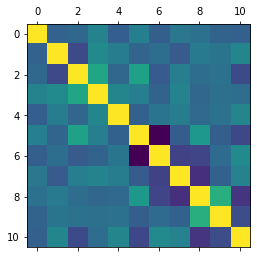

In [2]:
plt.matshow(df.corr())
plt.show()

In [3]:
#a_hum=(6.112*r_hum*math.exp((17.62*temp)/(243.12+temp)))/(461.5*(temp+273.15))
#df['a_hum'] = df.apply(lambda row: (6.112*row['r_hum']*math.exp((17.62*row['temp'])/(243.12+row['temp'])))/(461.5*(row['temp']+273.15)))
a_hum = []
counter = 0
for row in range(len(df['r_hum'])):
    ah=(6.112*df['r_hum'][row]*math.exp((17.62*df['temp'][row])/(243.12+df['temp'][row])))/(461.5*(df['temp'][row]+273.15))
    a_hum.append(ah)
df['a_hum']=a_hum

a_hum_e = []
counter = 0
for row in range(len(df['r_hum_e'])):
    ahe=(6.112*df['r_hum_e'][row]*math.exp((17.62*df['temp_e'][row])/(243.12+df['temp_e'][row])))/(461.5*(df['temp_e'][row]+273.15))
    a_hum_e.append(ahe)
df['a_hum_e']=a_hum_e

df.head()
#df=df.set_index('ds')

,ds,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum,a_hum_e
0,2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667,0.010100,0.005714
1,2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000,0.009896,0.005901
2,2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333,0.009783,0.005693
3,2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000,0.009689,0.005805
4,2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667,0.009570,0.005704


In [4]:
df=df.set_index('ds')
df['a_hum_prediction']=df['a_hum'].shift(-1, freq='H')
df.head()


,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum,a_hum_e,a_hum_prediction
ds,,,,,,,,,,,,,,
2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667,0.010100,0.005714,0.009896
2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000,0.009896,0.005901,0.009783
2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333,0.009783,0.005693,0.009689
2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000,0.009689,0.005805,0.009570
2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667,0.009570,0.005704,0.009592


In [5]:
df['Tw']=df['temp']-(2.42*(df['temp']-df['temp_e'])/8) #thermal bridge U-value = 2.42
df.head()

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum,a_hum_e,a_hum_prediction,Tw
ds,,,,,,,,,,,,,,,
2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667,0.010100,0.005714,0.009896,19.047165
2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000,0.009896,0.005901,0.009783,18.998600
2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333,0.009783,0.005693,0.009689,18.890012
2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000,0.009689,0.005805,0.009570,19.180285
2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667,0.009570,0.005704,0.009592,19.348526


In [6]:
df['wall_RH']=(df['a_hum_prediction']*461.5*(df['Tw']+273.15))/(6.112*np.exp((17.62*df['Tw'])/(243.12+df['Tw'])))

In [7]:
df['condensation alert'] = np.where(df['wall_RH']>75, 1, 0)

In [8]:
energy_sim_df=df[df['condensation alert']==1]

In [9]:
energy_sim_df.head()

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum,a_hum_e,a_hum_prediction,Tw,wall_RH,condensation alert
ds,,,,,,,,,,,,,,,,,
2021-01-17 09:00:00,7.0,26.258200,40.021200,1742.019000,81.145313,-6.92,100.0,1014.0,0.623333,200.0,67.666667,0.009862,0.002969,0.010374,16.221795,75.290326,1
2021-01-18 10:00:00,1.0,24.404377,42.925293,1099.137000,80.703320,-4.61,93.0,1022.0,0.495000,158.0,91.000000,0.009533,0.003263,0.010204,15.627528,76.761769,1
2021-01-18 17:00:00,1.0,28.102987,41.461447,1395.754000,80.985717,-8.17,93.0,1022.0,0.370000,232.0,30.333333,0.011314,0.002519,0.011618,17.130408,79.847328,1
2021-01-18 18:00:00,1.0,28.500853,41.657907,1743.684000,83.278517,-7.11,93.0,1022.0,2.570000,120.0,26.333333,0.011618,0.002723,0.011642,17.728570,77.207539,1
2021-01-18 19:00:00,1.0,28.652413,41.399387,1706.781667,85.147847,-6.06,86.0,1023.0,1.540000,110.0,40.000000,0.011642,0.002718,0.011713,18.151908,75.745399,1


In [10]:
energy_sim_df['passive possible'] = np.where(((energy_sim_df['aqi_e']<=50) & (energy_sim_df['a_hum_e']<energy_sim_df['a_hum'])), 1, 0)

In [11]:
energy_sim_df.head()

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum,a_hum_e,a_hum_prediction,Tw,wall_RH,condensation alert,passive possible
ds,,,,,,,,,,,,,,,,,,
2021-01-17 09:00:00,7.0,26.258200,40.021200,1742.019000,81.145313,-6.92,100.0,1014.0,0.623333,200.0,67.666667,0.009862,0.002969,0.010374,16.221795,75.290326,1,0
2021-01-18 10:00:00,1.0,24.404377,42.925293,1099.137000,80.703320,-4.61,93.0,1022.0,0.495000,158.0,91.000000,0.009533,0.003263,0.010204,15.627528,76.761769,1,0
2021-01-18 17:00:00,1.0,28.102987,41.461447,1395.754000,80.985717,-8.17,93.0,1022.0,0.370000,232.0,30.333333,0.011314,0.002519,0.011618,17.130408,79.847328,1,1
2021-01-18 18:00:00,1.0,28.500853,41.657907,1743.684000,83.278517,-7.11,93.0,1022.0,2.570000,120.0,26.333333,0.011618,0.002723,0.011642,17.728570,77.207539,1,1
2021-01-18 19:00:00,1.0,28.652413,41.399387,1706.781667,85.147847,-6.06,86.0,1023.0,1.540000,110.0,40.000000,0.011642,0.002718,0.011713,18.151908,75.745399,1,1


In [12]:
energy_sim_df['wind component']=energy_sim_df['wind_s'] * np.sin(energy_sim_df['wind_a'])
energy_sim_df['wind component'] = energy_sim_df['wind component'].clip(lower=0)
energy_sim_df.head()

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum,a_hum_e,a_hum_prediction,Tw,wall_RH,condensation alert,passive possible,wind component
ds,,,,,,,,,,,,,,,,,,,
2021-01-17 09:00:00,7.0,26.258200,40.021200,1742.019000,81.145313,-6.92,100.0,1014.0,0.623333,200.0,67.666667,0.009862,0.002969,0.010374,16.221795,75.290326,1,0,0.000000
2021-01-18 10:00:00,1.0,24.404377,42.925293,1099.137000,80.703320,-4.61,93.0,1022.0,0.495000,158.0,91.000000,0.009533,0.003263,0.010204,15.627528,76.761769,1,0,0.393933
2021-01-18 17:00:00,1.0,28.102987,41.461447,1395.754000,80.985717,-8.17,93.0,1022.0,0.370000,232.0,30.333333,0.011314,0.002519,0.011618,17.130408,79.847328,1,1,0.000000
2021-01-18 18:00:00,1.0,28.500853,41.657907,1743.684000,83.278517,-7.11,93.0,1022.0,2.570000,120.0,26.333333,0.011618,0.002723,0.011642,17.728570,77.207539,1,1,1.492171
2021-01-18 19:00:00,1.0,28.652413,41.399387,1706.781667,85.147847,-6.06,86.0,1023.0,1.540000,110.0,40.000000,0.011642,0.002718,0.011713,18.151908,75.745399,1,1,0.000000


In [13]:
energy_sim_df['ACH passive']=0.1*1.17*energy_sim_df['wind component']*3600/46.35

In [14]:
energy_sim_df.head()

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum,a_hum_e,a_hum_prediction,Tw,wall_RH,condensation alert,passive possible,wind component,ACH passive
ds,,,,,,,,,,,,,,,,,,,,
2021-01-17 09:00:00,7.0,26.258200,40.021200,1742.019000,81.145313,-6.92,100.0,1014.0,0.623333,200.0,67.666667,0.009862,0.002969,0.010374,16.221795,75.290326,1,0,0.000000,0.000000
2021-01-18 10:00:00,1.0,24.404377,42.925293,1099.137000,80.703320,-4.61,93.0,1022.0,0.495000,158.0,91.000000,0.009533,0.003263,0.010204,15.627528,76.761769,1,0,0.393933,3.579818
2021-01-18 17:00:00,1.0,28.102987,41.461447,1395.754000,80.985717,-8.17,93.0,1022.0,0.370000,232.0,30.333333,0.011314,0.002519,0.011618,17.130408,79.847328,1,1,0.000000,0.000000
2021-01-18 18:00:00,1.0,28.500853,41.657907,1743.684000,83.278517,-7.11,93.0,1022.0,2.570000,120.0,26.333333,0.011618,0.002723,0.011642,17.728570,77.207539,1,1,1.492171,13.559921
2021-01-18 19:00:00,1.0,28.652413,41.399387,1706.781667,85.147847,-6.06,86.0,1023.0,1.540000,110.0,40.000000,0.011642,0.002718,0.011713,18.151908,75.745399,1,1,0.000000,0.000000


In [15]:
energy_sim_df['passive time required'] = np.where((energy_sim_df['passive possible']!=0) & (energy_sim_df['ACH passive']!=0), np.abs(np.log(energy_sim_df['co_2']/400)/energy_sim_df['ACH passive']),0)
energy_sim_df['active time required']=np.abs(np.log(energy_sim_df['co_2']/400)/7)

In [16]:
energy_sim_df.columns

Index(['dan', 'temp', 'r_hum', 'co_2', 'aqi_i', 'temp_e', 'r_hum_e', 'press',
       'wind_s', 'wind_a', 'aqi_e', 'a_hum', 'a_hum_e', 'a_hum_prediction',
       'Tw', 'wall_RH', 'condensation alert', 'passive possible',
       'wind component', 'ACH passive', 'passive time required',
       'active time required'],
      dtype='object')

In [20]:
energy_sim_df['passive energy required'] = np.where((energy_sim_df['passive time required']<0.25)&(energy_sim_df['passive time required']!=0), 0.1, 0.33*energy_sim_df['ACH passive']*46.35*(20-energy_sim_df['temp_e'])*energy_sim_df['passive time required']) #0.1 to indicate near zero energy for passive ventilation that lasts less than 15 minutes
energy_sim_df['active energy required'] = 150*energy_sim_df['active time required']

In [21]:
energy_sim_df

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,...,Tw,wall_RH,condensation alert,passive possible,wind component,ACH passive,passive time required,active time required,passive energy required,active energy required
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-17 09:00:00,7.0,26.258200,40.021200,1742.019000,81.145313,-6.920000,100.000000,1014.000000,0.623333,200.000000,...,16.221795,75.290326,1,0,0.000000,0.000000,0.000000,0.210191,0.000000,31.528618
2021-01-18 10:00:00,1.0,24.404377,42.925293,1099.137000,80.703320,-4.610000,93.000000,1022.000000,0.495000,158.000000,...,15.627528,76.761769,1,0,0.393933,3.579818,0.000000,0.144402,0.000000,21.660344
2021-01-18 17:00:00,1.0,28.102987,41.461447,1395.754000,80.985717,-8.170000,93.000000,1022.000000,0.370000,232.000000,...,17.130408,79.847328,1,1,0.000000,0.000000,0.000000,0.178532,0.000000,26.779832
2021-01-18 18:00:00,1.0,28.500853,41.657907,1743.684000,83.278517,-7.110000,93.000000,1022.000000,2.570000,120.000000,...,17.728570,77.207539,1,1,1.492171,13.559921,0.108577,0.210327,0.100000,31.549090
2021-01-18 19:00:00,1.0,28.652413,41.399387,1706.781667,85.147847,-6.060000,86.000000,1023.000000,1.540000,110.000000,...,18.151908,75.745399,1,1,0.000000,0.000000,0.000000,0.207271,0.000000,31.090720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-08 06:00:00,4.0,25.382230,43.976137,1395.681000,49.786983,-7.110000,93.000000,1022.000000,1.540000,170.000000,...,15.553330,80.707983,1,1,0.533840,4.851208,0.257600,0.178525,518.190745,26.778711
2021-04-08 07:00:00,4.0,26.058673,43.827597,1089.178667,51.252727,-4.813333,88.333333,1022.666667,0.683333,303.333333,...,16.719891,80.939296,1,1,0.673524,6.120570,0.163664,0.143102,0.100000,21.465313
2021-04-08 08:00:00,4.0,26.373820,46.334410,1305.046000,51.993990,-2.110000,80.000000,1023.000000,0.510000,0.000000,...,17.757464,78.213272,1,1,0.000000,0.000000,0.000000,0.168933,0.000000,25.339908


In [22]:
energy_sim_df['passive feasible']=np.where(energy_sim_df['passive energy required']==0.1, 1, 0)
energy_sim_df.head()

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,...,wall_RH,condensation alert,passive possible,wind component,ACH passive,passive time required,active time required,passive energy required,active energy required,passive feasible
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-17 09:00:00,7.0,26.258200,40.021200,1742.019000,81.145313,-6.92,100.0,1014.0,0.623333,200.0,...,75.290326,1,0,0.000000,0.000000,0.000000,0.210191,0.0,31.528618,0
2021-01-18 10:00:00,1.0,24.404377,42.925293,1099.137000,80.703320,-4.61,93.0,1022.0,0.495000,158.0,...,76.761769,1,0,0.393933,3.579818,0.000000,0.144402,0.0,21.660344,0
2021-01-18 17:00:00,1.0,28.102987,41.461447,1395.754000,80.985717,-8.17,93.0,1022.0,0.370000,232.0,...,79.847328,1,1,0.000000,0.000000,0.000000,0.178532,0.0,26.779832,0
2021-01-18 18:00:00,1.0,28.500853,41.657907,1743.684000,83.278517,-7.11,93.0,1022.0,2.570000,120.0,...,77.207539,1,1,1.492171,13.559921,0.108577,0.210327,0.1,31.549090,1
2021-01-18 19:00:00,1.0,28.652413,41.399387,1706.781667,85.147847,-6.06,86.0,1023.0,1.540000,110.0,...,75.745399,1,1,0.000000,0.000000,0.000000,0.207271,0.0,31.090720,0


In [23]:
energy_sim_df[energy_sim_df['passive feasible']==1] #33 cases out of 174 cases, or 18.96%

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,...,wall_RH,condensation alert,passive possible,wind component,ACH passive,passive time required,active time required,passive energy required,active energy required,passive feasible
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-18 18:00:00,1.0,28.500853,41.657907,1743.684000,83.278517,-7.110000,93.000000,1022.000000,2.570000,120.000000,...,77.207539,1,1,1.492171,13.559921,0.108577,0.210327,0.1,31.549090,1
2021-01-25 08:00:00,1.0,27.256090,42.862860,1989.043000,93.385860,-2.110000,100.000000,1003.000000,1.545000,115.000000,...,75.027464,1,1,1.460698,13.273912,0.120834,0.229135,0.1,34.370236,1
2021-01-26 16:00:00,2.0,26.241150,43.306017,1304.918000,87.429370,-1.060000,93.000000,1011.000000,3.600000,310.000000,...,76.934401,1,1,3.063196,27.836419,0.042478,0.168919,0.1,25.337806,1
2021-01-26 19:00:00,2.0,28.297437,44.400853,1997.769333,90.803060,-2.110000,100.000000,1013.000000,2.570000,310.000000,...,75.747146,1,1,2.186781,19.872110,0.080934,0.229760,0.1,34.464042,1
2021-02-11 18:00:00,4.0,26.703690,48.016370,1748.978250,88.682645,-1.060000,86.000000,1016.000000,5.140000,310.000000,...,78.561456,1,1,4.373563,39.744220,0.037120,0.210760,0.1,31.614053,1
2021-02-12 01:00:00,5.0,25.541810,46.182773,1516.010000,86.789747,-5.815000,68.000000,1023.000000,3.860000,335.000000,...,78.396925,1,1,3.523921,32.023206,0.041606,0.190339,0.1,28.550842,1
2021-02-12 04:00:00,5.0,24.877147,45.256753,1515.882000,84.741377,-6.060000,63.000000,1024.000000,3.600000,310.000000,...,78.622873,1,1,3.063196,27.836419,0.047861,0.190327,0.1,28.549032,1
2021-02-12 05:00:00,5.0,24.950337,45.334817,1624.029667,83.889747,-6.060000,68.000000,1024.000000,3.600000,310.000000,...,81.815761,1,1,3.063196,27.836419,0.050337,0.200172,0.1,30.025741,1
2021-02-12 06:00:00,5.0,25.578103,45.683780,1775.221000,85.841227,-6.060000,64.666667,1024.666667,3.260000,310.000000,...,82.974735,1,1,2.773894,25.207424,0.059118,0.212888,0.1,31.933193,1


In [27]:
(np.sum(energy_sim_df[energy_sim_df['passive feasible']==1]['active energy required'])/np.sum(energy_sim_df['active energy required']))*100

18.69309761456822

In [28]:
#savings up to 18.69% of energy required for ventilation